## Feature extraction

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

import afdetection.utils.paths as path
from afdetection.data.make_dataset import MakeDataset
from afdetection.data.signal_preprocessing import SignalPreprocessing
from afdetection.features.build_features import BuildFeatures

sns.set_theme()

## Load ECGs

In [33]:
# Leads names
leads = [
    'I',
    'II', 
    'III', 
    'aVF', 
    'aVR', 
    'aVL', 
    'V1', 
    'V2', 
    'V3', 
    'V4', 
    'V5', 
    'V6', 
]

fs = 500 # Sampling frequency

# Intantiate objects
make_data = MakeDataset()

# Load ECGs
ecg_data_DIR = path.data_raw_dir('ecgeq-500hzsrfava.npy')
ecg = make_data.read_from_np(ecg_data_DIR)

## Preprocessing

In [34]:
preprocessing = SignalPreprocessing()

### Wander removal

In [35]:
ecg_wr = preprocessing.wander_removal(ecg, fs)

# Remove first and last second of the ECGs
ecg_wr_crop = ecg_wr[:, 1*fs:-1*fs, :]
m, n, lead = ecg_wr_crop.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

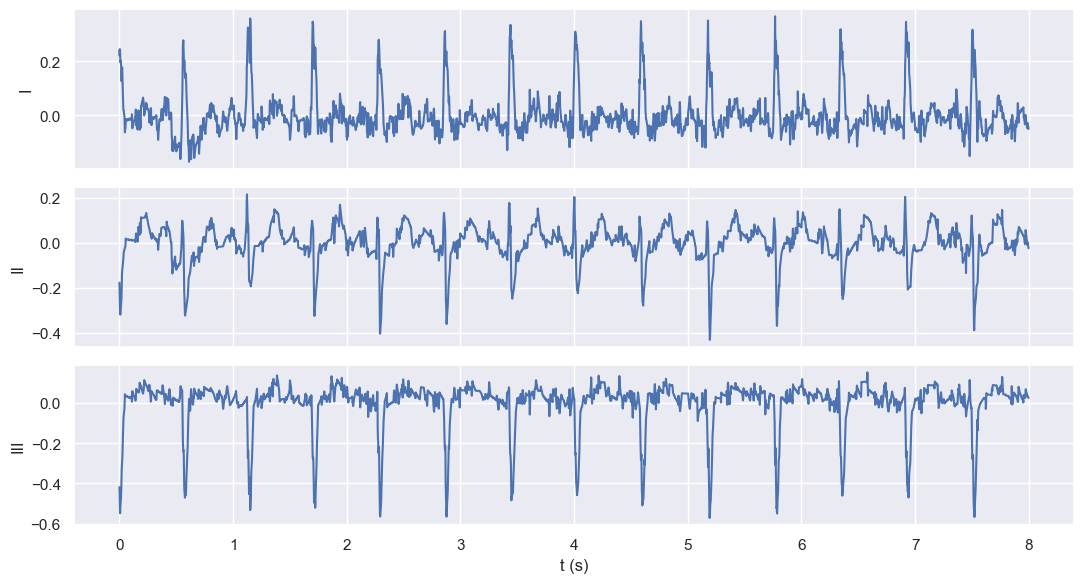

In [36]:
idx = np.random.randint(0, m)
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecg_wr_crop[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

### Pan–Tompkins algorithm preprocessing

In [37]:
w = int((150/1000)*fs)  # Moving average window size (150ms)
ecg_qrs = preprocessing.pan_tompkins(ecg_wr, fs, w)

# Remove first and last second of the ECGs
ecg_qrs_crop = ecg_qrs[:, 1*fs:-1*fs, :]
m, n, lead = ecg_qrs_crop.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

# Mean removal
# ecg_mr = preprocessing.mean_removal(ecg_qrs_crop)

# Normalize
# ecg_n = preprocessing.normalize(ecg_mr)

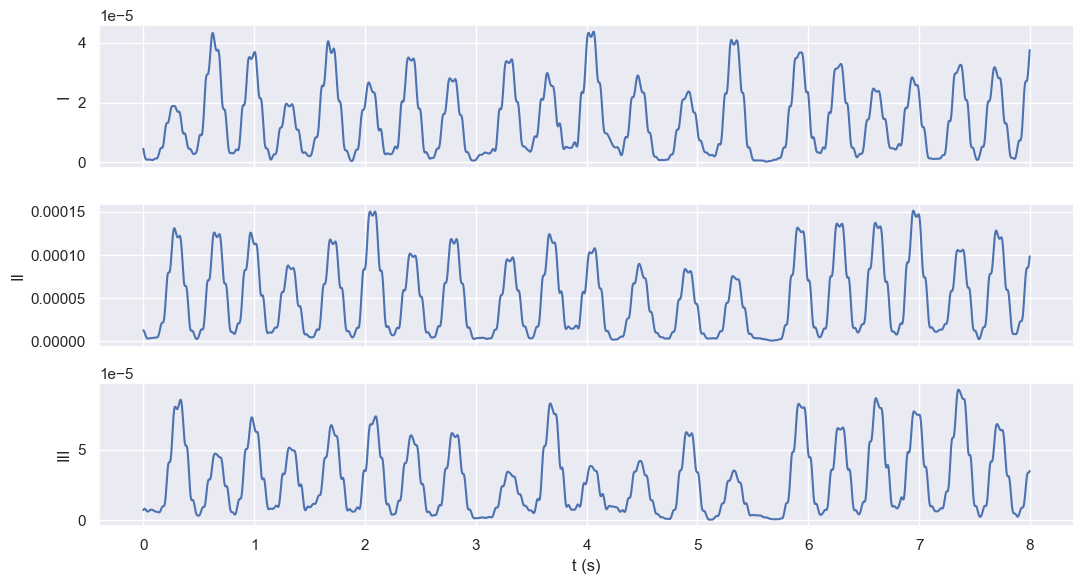

In [38]:
idx = np.random.randint(0, m)
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecg_qrs_crop[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

## Visualize frequency content

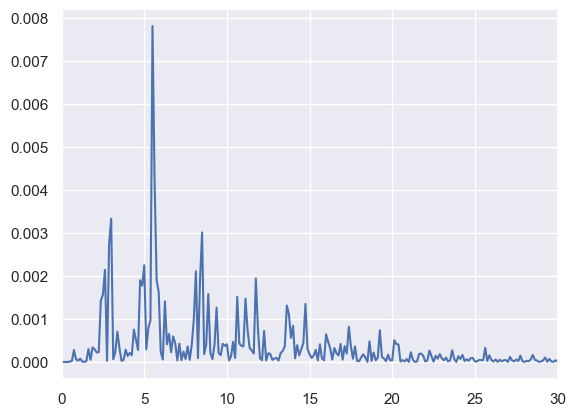

In [39]:
x = ecg_wr_crop[idx, :, 1].ravel()
freqs, Pxx = signal.periodogram(x, fs)

plt.plot(freqs, Pxx)
plt.xlim([0, 30])
plt.show()

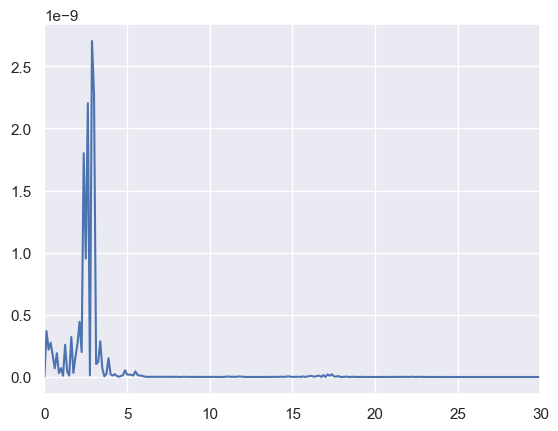

In [40]:
x = ecg_qrs_crop[idx, :, 1].ravel()
freqs, Pxx = signal.periodogram(x, fs)

plt.plot(freqs, Pxx)
plt.xlim([0, 30])
plt.show()

## Build features

In [41]:
build_features = BuildFeatures()

### Spectral Entropy

In [42]:
# spectral_entropy = build_features.spectral_entropy_ecg(ecg_wr_crop, fs)
spectral_entropy = build_features.spectral_entropy_ecg(ecg_qrs_crop, fs)

In [43]:
ecg_specEn = pd.DataFrame(spectral_entropy, columns=leads)
ecg_specEn = ecg_specEn.add_suffix('_specEn')
display(ecg_specEn)

,I_specEn,II_specEn,III_specEn,aVF_specEn,aVR_specEn,aVL_specEn,V1_specEn,V2_specEn,V3_specEn,V4_specEn,V5_specEn,V6_specEn
0,1.676562,1.749363,2.268625,1.619254,1.800733,3.689650,2.767865,1.648685,1.697787,1.722314,1.673624,1.665973
1,1.676562,1.749363,2.268625,1.619254,1.800733,3.689650,2.767865,1.648685,1.697787,1.722314,1.673624,1.665973
2,2.506706,3.009748,4.409531,2.716170,2.436821,3.529405,2.677661,2.485850,2.547367,2.560969,2.608803,2.620466
3,1.148147,1.770946,2.465908,1.310650,1.089540,3.134664,0.855291,0.934886,1.486309,1.628305,1.023943,0.960868
4,3.612966,3.438919,3.890226,3.533026,3.717453,3.454853,3.560670,3.558945,3.536269,3.542047,3.571731,3.563359
...,...,...,...,...,...,...,...,...,...,...,...,...
6423,4.274991,4.221741,4.123835,4.312194,4.180064,4.145448,4.166901,4.100227,4.067787,4.075380,4.086429,4.111189
6424,3.773754,3.962813,3.920919,3.804665,3.799965,4.011297,3.935180,4.519224,4.243808,4.351523,3.767230,3.888101
6425,3.286940,3.899100,3.107284,3.880709,3.043798,3.279540,2.877888,2.852879,3.145880,2.951448,3.086531,3.104690
6426,4.338848,4.284936,4.225550,4.180253,4.124905,4.287628,4.201825,4.117103,4.095786,4.115953,4.148973,4.224494


In [44]:
data_DIR = path.data_raw_dir('ecg_features_spectral_entropy.csv')
ecg_specEn.to_csv(data_DIR, index=False)

### Dominant frequency

In [45]:
# dominant_frequency = build_features.dominant_frequency_ecg(ecg_wr_crop, fs)
dominant_frequency = build_features.dominant_frequency_ecg(ecg_qrs_crop, fs)

In [46]:
ecg_dFreq = pd.DataFrame(dominant_frequency, columns=leads)
ecg_dFreq = ecg_dFreq.add_suffix('_dFreq')
display(ecg_dFreq)

,I_dFreq,II_dFreq,III_dFreq,aVF_dFreq,aVR_dFreq,aVL_dFreq,V1_dFreq,V2_dFreq,V3_dFreq,V4_dFreq,V5_dFreq,V6_dFreq
0,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375
1,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375
2,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500,1.500
3,2.125,2.125,2.125,2.125,2.125,4.250,2.125,2.125,2.125,2.125,2.125,2.125
4,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750,0.750
...,...,...,...,...,...,...,...,...,...,...,...,...
6423,1.000,1.000,1.125,1.000,1.000,1.000,1.125,1.125,1.125,1.125,1.125,1.125
6424,1.750,1.750,1.750,1.750,1.750,1.750,1.750,0.875,1.750,1.750,1.750,1.750
6425,2.625,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375,1.375
6426,1.625,0.625,1.000,1.000,1.625,0.625,1.000,1.625,1.625,1.625,1.625,1.625


In [47]:
data_DIR = path.data_raw_dir('ecg_features_dominant_frequency.csv')
ecg_dFreq.to_csv(data_DIR, index=False)

### Wavelet features

1. Energy
2. Mean
3. variance
4. standard deviation

In [48]:
wavelet = 'db4'
level = 5

wavelet_features = build_features.wave_dec_coeffs_ecg(ecg_wr_crop, wavelet=wavelet, level=level)
print(wavelet_features.shape)

w_statistics = ['energy', 'mean', 'varance', 'std_dev']
w_coeff = ([f'cA{level}'] + [f'cD{i}' for i in range(level, 0, -1)])

w_features = [f"{x}_{y}" for y in w_statistics for x in w_coeff]

_, _, n_wf = wavelet_features.shape

ecg_waveFeat = pd.DataFrame()
for lead in range(len(leads)):
    ecg_wf = pd.DataFrame(wavelet_features[:, lead, :], columns=w_features)
    ecg_wf = ecg_wf.add_prefix(leads[lead] + '_')
    ecg_waveFeat = pd.concat([ecg_waveFeat, ecg_wf], axis=1)

display(ecg_waveFeat)

(6428, 12, 24)


,I_cA5_energy,I_cD5_energy,I_cD4_energy,I_cD3_energy,I_cD2_energy,I_cD1_energy,I_cA5_mean,I_cD5_mean,I_cD4_mean,I_cD3_mean,...,V6_cD4_varance,V6_cD3_varance,V6_cD2_varance,V6_cD1_varance,V6_cA5_std_dev,V6_cD5_std_dev,V6_cD4_std_dev,V6_cD3_std_dev,V6_cD2_std_dev,V6_cD1_std_dev
0,55.013139,96.480633,121.504127,13.488700,0.591159,0.111367,0.007545,0.019542,-0.020092,0.000320,...,0.299161,0.017554,0.000348,0.000016,0.667444,0.703703,0.546956,0.132492,0.018643,0.003989
1,55.013139,96.480633,121.504127,13.488700,0.591159,0.111367,0.007545,0.019542,-0.020092,0.000320,...,0.299161,0.017554,0.000348,0.000016,0.667444,0.703703,0.546956,0.132492,0.018643,0.003989
2,41.573709,20.138983,7.832812,0.944590,0.082381,0.033544,0.057802,0.011346,-0.002484,0.000241,...,0.096518,0.005676,0.000093,0.000010,0.957680,0.664210,0.310673,0.075337,0.009657,0.003106
3,61.783369,51.065864,53.527336,11.363368,1.552001,0.406809,0.035166,-0.021319,0.006677,-0.000152,...,0.408738,0.033690,0.000812,0.000039,1.002384,0.884537,0.639326,0.183548,0.028496,0.006259
4,23.353338,13.608418,4.542217,0.980550,0.189123,0.044602,0.028104,0.010936,-0.002755,-0.000089,...,0.043650,0.004678,0.000051,0.000005,0.709681,0.470671,0.208927,0.068397,0.007155,0.002160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6423,8.502504,2.768978,2.274819,0.378829,0.067696,0.023346,-0.003003,-0.006054,0.003288,-0.000916,...,0.017666,0.001845,0.000050,0.000004,0.311259,0.242404,0.132913,0.042949,0.007041,0.002055
6424,51.284600,9.643762,3.406913,0.625492,0.209773,0.064470,-0.000955,0.008885,0.000422,-0.000109,...,0.149956,0.008008,0.000477,0.000028,1.269286,0.754848,0.387241,0.089486,0.021846,0.005279
6425,11.661859,5.792339,3.894952,2.313951,1.974222,0.757749,-0.013060,0.015865,0.007551,-0.001094,...,0.036305,0.003755,0.000205,0.000027,0.368449,0.297393,0.190539,0.061281,0.014315,0.005233
6426,15.923179,8.861932,3.909852,1.520737,0.447607,0.113704,-0.010377,0.011733,-0.001891,-0.002416,...,0.020426,0.001005,0.000062,0.000008,0.778719,0.314996,0.142921,0.031701,0.007852,0.002823


In [49]:
data_DIR = path.data_raw_dir('ecg_features_wavelet.csv')
ecg_waveFeat.to_csv(data_DIR, index=False)